In [13]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model

In [14]:
(x_train, _), (x_test, _) = fashion_mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

print (x_train.shape)
print (x_test.shape)

(60000, 28, 28)
(10000, 28, 28)


In [45]:
latent_dim = 64 

class Denoise(Model):
  def __init__(self):
    super().__init__()
    self.encoder = tf.keras.Sequential([
      layers.Input(shape=(28, 28, 1)),
      layers.Conv2D(32, (3, 3), activation='relu', padding='same', strides=1),
      layers.Conv2D(16, (3, 3), activation='relu', padding='same', strides=1),
      layers.Conv2D(8, (3, 3), activation='relu', padding='same', strides=1)])

    self.decoder = tf.keras.Sequential([
      layers.Conv2DTranspose(8, kernel_size=3, strides=1, activation='relu', padding='same'),
      layers.Conv2DTranspose(16, kernel_size=3, strides=1, activation='relu', padding='same'),
      layers.Conv2DTranspose(32, kernel_size=3, strides=1, activation='relu', padding='same'),
      layers.Conv2D(1, kernel_size=(3, 3), activation='sigmoid', padding='same')])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

autoencoder = Denoise() 

In [46]:
autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())

In [47]:
history = autoencoder.fit(x_train, x_train,
                epochs=10,
                shuffle=True,
                validation_data=(x_test, x_test))

Epoch 1/10


2023-04-27 12:21:53.019525: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1872/1875 [============================>.] - ETA: 0s - loss: 0.0031

2023-04-27 12:22:09.268876: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1875/1875 [==============================] - 18s 9ms/step - loss: 0.0031 - val_loss: 3.7994e-04
Epoch 2/10
1875/1875 [==============================] - 17s 9ms/step - loss: 2.0512e-04 - val_loss: 2.0137e-04
Epoch 3/10
1875/1875 [==============================] - 16s 9ms/step - loss: 1.1183e-04 - val_loss: 7.1069e-05
Epoch 4/10
1875/1875 [==============================] - 16s 9ms/step - loss: 8.1320e-05 - val_loss: 3.9901e-05
Epoch 5/10
1875/1875 [==============================] - 17s 9ms/step - loss: 6.1573e-05 - val_loss: 1.6211e-04
Epoch 6/10
1875/1875 [==============================] - 17s 9ms/step - loss: 4.8250e-05 - val_loss: 1.0752e-04
Epoch 7/10
1875/1875 [==============================] - 17s 9ms/step - loss: 4.2905e-05 - val_loss: 2.0102e-05
Epoch 8/10
1875/1875 [==============================] - 17s 9ms/step - loss: 3.7886e-05 - val_loss: 2.3095e-05
Epoch 9/10
1875/1875 [==============================] - 18s 9ms/step - loss: 3.0715e-05 - val_loss: 7.8932e-05
Epoch 10/10
1875

In [48]:
encoded_imgs = autoencoder.encoder(x_test).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

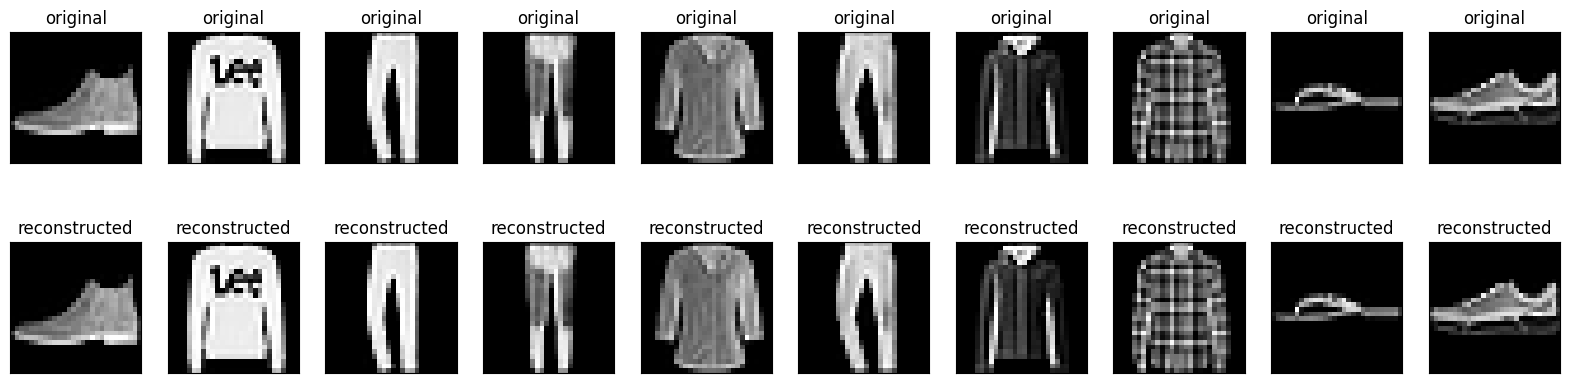

In [49]:
n = 10
plt.figure(figsize=(20, 5))
for i in range(n):
  # display original
  ax = plt.subplot(2, n, i + 1)
  plt.imshow(x_test[i])
  plt.title("original")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  # display reconstruction
  ax = plt.subplot(2, n, i + 1 + n)
  plt.imshow(decoded_imgs[i])
  plt.title("reconstructed")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
plt.show()

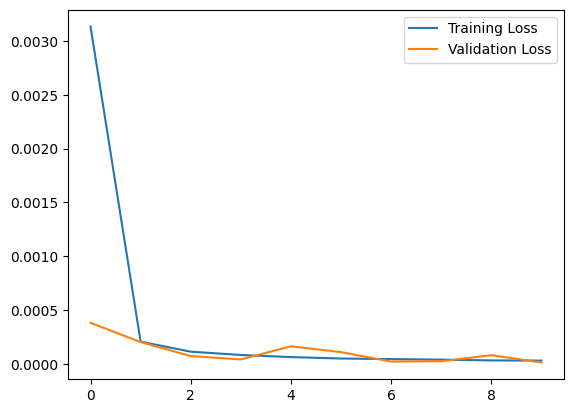

In [50]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()

In [51]:
noise_factor = 0.03
x_train_noisy = x_train + noise_factor * tf.random.normal(shape=x_train.shape) 
x_test_noisy = x_test + noise_factor * tf.random.normal(shape=x_test.shape) 

x_train_noisy = tf.clip_by_value(x_train_noisy, clip_value_min=0., clip_value_max=1.)
x_test_noisy = tf.clip_by_value(x_test_noisy, clip_value_min=0., clip_value_max=1.)

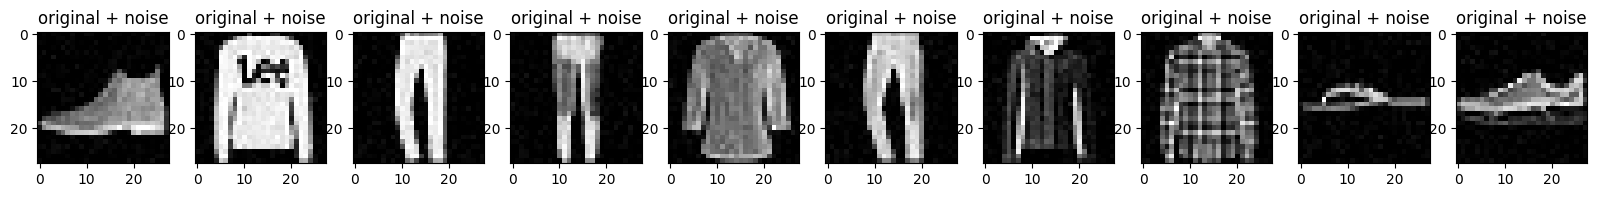

In [52]:
n = 10
plt.figure(figsize=(20, 2))
for i in range(n):
    ax = plt.subplot(1, n, i + 1)
    plt.title("original + noise")
    plt.imshow(tf.squeeze(x_test_noisy[i]))
    plt.gray()
plt.show()

  18/1875 [..............................] - ETA: 11s

2023-04-27 12:24:45.147031: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1875/1875 [==============================] - 8s 4ms/step


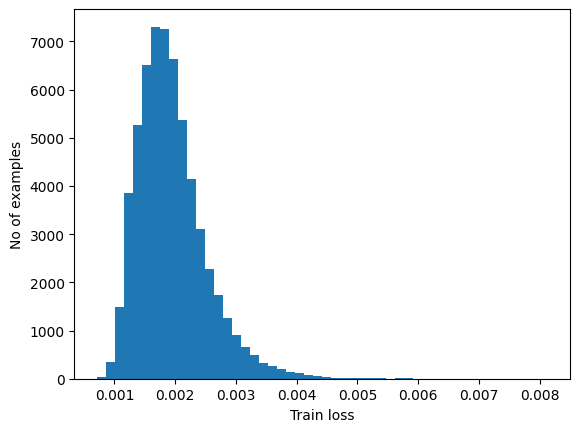

In [53]:
reconstructions = autoencoder.predict(x_train)
train_loss = tf.keras.losses.mae(
    np.squeeze(reconstructions).reshape(-1, 28 * 28), x_train.reshape(-1, 28 * 28)
)

plt.hist(train_loss[None, :], bins=50)
plt.xlabel("Train loss")
plt.ylabel("No of examples")
plt.show()


In [54]:
threshold = np.mean(train_loss) + np.std(train_loss)
print("Threshold: ", threshold)

Threshold:  tf.Tensor(0.002511188, shape=(), dtype=float32)


 26/313 [=>............................] - ETA: 1s

2023-04-27 12:24:54.323797: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


313/313 [==============================] - 1s 4ms/step


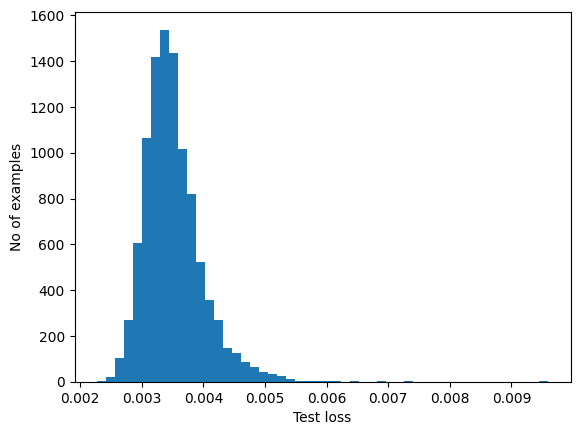

In [55]:
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()

reconstructions = autoencoder.predict(x_test_noisy)
test_loss = tf.keras.losses.mae(
    np.squeeze(reconstructions).reshape(-1, 28 * 28), x_test_noisy.reshape(-1, 28 * 28)
)

plt.hist(test_loss[None, :], bins=50)
plt.xlabel("Test loss")
plt.ylabel("No of examples")
plt.show()


In [56]:
def predict(model, data, threshold):
    reconstructions = model(data)
    loss = tf.keras.losses.mae(
        np.squeeze(reconstructions).reshape(-1, 28 * 28), data.reshape(-1, 28 * 28)
    )
    return tf.math.less(loss, threshold)


def print_stats(predictions, labels):
    print("Accuracy = {}".format(accuracy_score(labels, predictions)))
    print("Precision = {}".format(precision_score(labels, predictions)))
    print("Recall = {}".format(recall_score(labels, predictions)))


In [57]:
preds = predict(autoencoder, x_test_noisy, threshold)
# print_stats(preds, test_labels)

In [58]:
tf.keras.losses.mae(
    np.squeeze(reconstructions).reshape(-1, 28 * 28), x_test_noisy.reshape(-1, 28 * 28)
)


<tf.Tensor: shape=(10000,), dtype=float32, numpy=
array([0.00304807, 0.00524445, 0.00390003, ..., 0.00335356, 0.00331385,
       0.00294544], dtype=float32)>

In [59]:
preds

<tf.Tensor: shape=(10000,), dtype=bool, numpy=array([False, False, False, ..., False, False, False])>

In [60]:
tf.keras.losses.mae([[1,1,0,0],[1,1,0,0]],[[1,1,1,1],[1,1,1,1]])

<tf.Tensor: shape=(2,), dtype=int32, numpy=array([0, 0], dtype=int32)>

In [61]:
import torch
ref = torch.normal(mean=0., std=torch.full([5000], 1.))

In [62]:
torch.tensor([0.5,0.5] )- torch.mean(ref)

tensor([0.5050, 0.5050])